# Transformer Model for English-to-French Translation

This Colab notebook implements a Transformer model for translating English sentences into French. The model is built using TensorFlow/Keras and includes steps for data preprocessing, model definition, training, evaluation, and inference.

# Setup and Data Loading

- Import necessary libraries, including TensorFlow, NumPy, Pandas, and Matplotlib.
- Load the English-to-French dataset (`eng_-french.csv`) and preprocess it for model training.
- Lowercase all text for consistency and add special tokens `<sos>` (start of sequence) and `<eos>` (end of sequence) to mark the start and end of each sentence.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, Input, Dropout, LayerNormalization

import os

In [ ]:
devices = tf.config.experimental.list_physical_devices("GPU") #GPU
for device in devices:
    tf.config.experimental.set_memory_growth(device=device, enable=True)

In [ ]:
# Set TensorFlow to use only the CPU
#tf.config.set_visible_devices([], 'GPU')
#print("Using CPU only")

In [ ]:
df = pd.read_csv("eng_-french.csv")
df.columns = ["en", "fr"]

In [ ]:
df.head()

,en,fr
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !


In [ ]:
df["en"] = df["en"].str.lower()
df["fr"] = df["fr"].str.lower()

In [ ]:
en_data = df["en"].values
fr_data = df["fr"].values

In [ ]:
for i in range(fr_data.shape[0]):
    en_data[i] = "sos " + str(en_data[i]) + " eos"
    fr_data[i] = "sos " + str(fr_data[i]) + " eos"

# Tokenization and Padding

- Use TensorFlow's `Tokenizer` to tokenize English and French sentences.
- Convert sentences into sequences of integer tokens representing words.
- Pad these sequences to a fixed length of 10 using `pad_sequences` to ensure uniform input sizes for the model.


In [ ]:
num_words = 10000
tokenizer_en = Tokenizer(num_words=num_words, filters='!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')
tokenizer_en.fit_on_texts(en_data)
englist_sentances = tokenizer_en.texts_to_sequences(en_data)

In [ ]:
word_index = tokenizer_en.word_index
print(f"Num words in English: {len(word_index)}")

Num words in English: 14149


In [ ]:
tokenizer_fr = Tokenizer(num_words=num_words, filters='!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')
tokenizer_fr.fit_on_texts(fr_data)
french_sentences = tokenizer_fr.texts_to_sequences(fr_data)

In [ ]:
word_index_fr = tokenizer_fr.word_index
print(f"Num words in French: {len(word_index_fr)}")

Num words in French: 27762


In [ ]:
english_sentences = pad_sequences(englist_sentances, maxlen=10, padding='post', truncating='post')
french_sentences = pad_sequences(french_sentences, maxlen=10, padding='post', truncating='post')

# Positional Encoding

- Define a function for generating positional encodings, which add positional information to the input embeddings.
- Use sinusoidal functions (sine for even indices and cosine for odd indices) to compute positional encodings.
- Visualize the positional encodings as a heatmap for better understanding.


In [ ]:
def get_angles(pos, i, embedding_dim):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(embedding_dim))
    return pos * angle_rates

Function to compute the angles for positional encoding. Returns the angle computed

In [ ]:
def positional_encoding(position, embedding_dim):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(embedding_dim)[np.newaxis, :],
                            embedding_dim)

    # apply sin to even indices in the array, i.e., 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array, i.e., 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

Adds positional encoding to the embeddings to be fed to the Transformer model.

Computes a sin and cos of the angles determined by the get_angles() function
and adds the value computed to an axis of the embeddings.


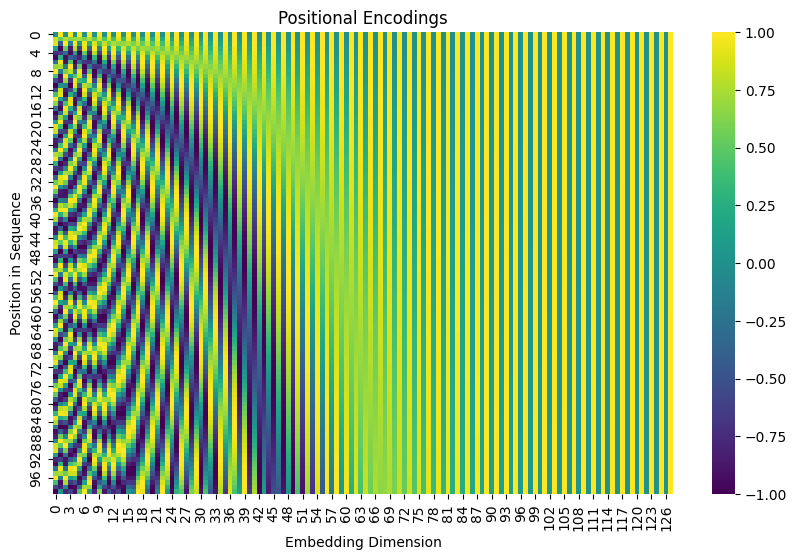

In [ ]:
# Generate positional encodings
pos_encodings = positional_encoding(100, 128)

# Visualize the encodings as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pos_encodings[0], cmap='viridis')
plt.xlabel('Embedding Dimension')
plt.ylabel('Position in Sequence')
plt.title('Positional Encodings')
plt.show()

In [ ]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

In [ ]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

In [ ]:
def create_masks(inputs, targets):
    enc_padding_mask = create_padding_mask(inputs)
    dec_padding_mask = create_padding_mask(inputs)
    look_ahead_mask = create_look_ahead_mask(tf.shape(targets)[1])
    dec_target_padding_mask = create_padding_mask(targets)
    combine_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combine_mask, dec_padding_mask

# Attention Mechanisms

- Define the scaled dot-product attention, the core component of the Transformer model.
- Implement a multi-head attention mechanism, which splits queries, keys, and values into multiple attention heads for better learning.
- These mechanisms allow the model to focus on different parts of the input sequence simultaneously.


In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], dtype=tf.float32)
    scaled_dk = tf.math.sqrt(dk)
    scaled_attention_logits = matmul_qk / scaled_dk
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)
    return output, attention_weights

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, key_dim, num_heads, dropout_rate=0.0):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.key_dim = key_dim

        assert key_dim % num_heads == 0
        self.depth = self.key_dim // self.num_heads

        self.wq = Dense(key_dim)
        self.wk = Dense(key_dim)
        self.wv = Dense(key_dim)

        self.dropout = Dropout(dropout_rate)
        self.dense = Dense(key_dim)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask=None):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.key_dim))
        output = self.dense(concat_attention)
        output = self.dropout(output)

        return output, attention_weights

Multi-head attention layer:

    Args:
    key_dim (int): The dimension of the key vectors.
    num_heads (int): The number of attention heads.
    dropout_rate (float, optional): The dropout rate for regularization. Default is 0.0.
  
Multi-HeadAttention Call:

    Forward pass through the multi-head attention layer.

    Args:
    v (tf.Tensor): The value vectors.
    k (tf.Tensor): The key vectors.
    q (tf.Tensor): The query vectors.
    mask: The mask to be applied in scaled dot product attention.

    Returns:
    tf.Tensor: The output tensor.
    tf.Tensor: The attention weights.


# Encoder and Decoder

- Build the Transformer encoder and decoder, each composed of multiple layers of attention and feedforward networks.
- The encoder processes the input sequence and generates a context vector.
- The decoder uses this context vector along with target sequences to predict the next word in the sequence.


In [ ]:
def FeedForward(embedding_dim, fully_connected_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(fully_connected_dim, activation='relu'),
        tf.keras.layers.Dense(embedding_dim)
    ])
    return model

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(embedding_dim, num_heads, dropout_rate)

        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)

        self.dropout = Dropout(dropout_rate)

        # Feedforward network
        self.ffn = FeedForward(embedding_dim, fully_connected_dim)

    def call(self, x, training, mask):
        # Apply multi-head self-attention mechanism to input tensor
        attn_output, _ = self.mha(x, x, x, mask=mask)

        out1 = self.layernorm1(attn_output + x)

        # Apply feedforward network to output of first layer normalization
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout(ffn_output, training=training)

        out2 = self.layernorm2(ffn_output + out1)

        return out2

EncoderLayer:

    A single layer of the encoder in a Transformer model.

    Args:
    embedding_dim (int): The dimension of the input embeddings.
    num_heads (int): The number of attention heads in the multi-head attention mechanism.
    fully_connected_dim (int): The dimension of the fully connected feedforward network.
    dropout_rate (float, optional): The dropout rate to be applied. Default is 0.1.

EncoderLayer Call:

    Forward pass through the encoder layer.

    Args:
    x (tf.Tensor): The input tensor.
    training (bool): Whether the model is in training mode.
    mask: The mask to be applied in multi-head attention.

    Returns:
    tf.Tensor: The output tensor after passing through the encoder layer.

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, maximum_position_encoding, dropout_rate=0.1):
        super(Encoder, self).__init__()

        self.num_layers = num_layers
        self.embedding_dim = embedding_dim

        # Embedding Layer
        self.embedding = Embedding(input_vocab_size, embedding_dim)

        # Positional encoding
        self.pos_encoding = positional_encoding(maximum_position_encoding, embedding_dim)

        # Encoder Layers
        self.enc_layers = [EncoderLayer(embedding_dim, num_heads, fully_connected_dim, dropout_rate) for _ in range(num_layers)]

        # Dropout Layer
        self.dropout = Dropout(dropout_rate)

    def call(self, inputs, training, mask):
        seq_len = tf.shape(inputs)[1]
        inputs = self.embedding(inputs)
        inputs *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))

        # Add positional encodings to the input sequence
        inputs += self.pos_encoding[:, :seq_len, :]

        inputs = self.dropout(inputs, training=training)

        # Pass the input sequence through the encoder layers
        for i in range(self.num_layers):
            inputs = self.enc_layers[i](inputs, training=training, mask=mask)

        return inputs

Encoder:

    Args:
    num_layers (int): The number of encoder layers.
    embedding_dim (int): The dimension of the input embeddings.
    num_heads (int): The number of attention heads in the multi-head attention mechanism.
    fully_connected_dim (int): The dimension of the fully connected feedforward network.
    input_vocab_size (int): The size of the input vocabulary.
    maximum_position_encoding (int): The maximum position for positional encoding.
    dropout_rate (float, optional): The dropout rate to be applied. Default is 0.1.

Encoder Call:

    Forward pass through the encoder.

    Args:
    inputs (tf.Tensor): The input sequence tensor.
    training (bool): Whether the model is in training mode.
    mask: The mask to be applied in multi-head attention.

    Returns:
    tf.Tensor: The encoded sequence tensor.

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(embedding_dim, num_heads, dropout_rate)
        self.mha2 = MultiHeadAttention(embedding_dim, num_heads, dropout_rate)

        self.ffn = FeedForward(embedding_dim, fully_connected_dim)

        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.layernorm3 = LayerNormalization(epsilon=1e-6)

        self.dropout3 = Dropout(dropout_rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # Apply the first multi-head attention layer to the query vector x.
        # We pass x as all three inputs to the layer because this is a self-attention layer.
        attn1, attn_weights_block1 = self.mha1(x, x, x, mask=look_ahead_mask)

        out1 = self.layernorm1(attn1 + x)

        # Apply the second multi-head attention layer to the output from the first layer and the encoder output.
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, mask=padding_mask)

        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)

        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2

DecoderLayer:

    Initializes a single decoder layer of the transformer model.

    Args:
    embedding_dim: The dimension of the embedding space.
    num_heads: The number of attention heads to use.
    fully_connected_dim: The dimension of the feedforward network.
    rate: The dropout rate for regularization.

DecoderLayer Call:

    Forward pass through the decoder layer.

    Args:
    x (tf.Tensor): The input tensor.
    enc_output (tf.Tensor): The output from the encoder layer.
    training (bool): Whether the model is in training mode.
    look_ahead_mask: The mask for look-ahead in multi-head attention.
    padding_mask: The mask for padding in multi-head attention.

    Returns:
    tf.Tensor: The output tensor after passing through the decoder layer.
    tf.Tensor: The attention weights for the first multi-head attention.
    tf.Tensor: The attention weights for the second multi-head attention.

In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, target_vocab_size, maximum_position_encoding, dropout_rate=0.1):
        super(Decoder, self).__init__()

        self.num_layers = num_layers
        self.embedding_dim = embedding_dim

        self.embedding = Embedding(target_vocab_size, embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, embedding_dim)
        self.dec_layers = [DecoderLayer(embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1) for _ in range(num_layers)]
        self.dropout = Dropout(dropout_rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        # add embedding and positional encoding
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)

        # apply each layer of the decoder
        for i in range(self.num_layers):
            # pass through decoder layer i
            x, block1, block2 = self.dec_layers[i](x=x, enc_output=enc_output, training=training, look_ahead_mask=look_ahead_mask, padding_mask=padding_mask)

            attention_weights[f"decoder_layer{i + 1}_block1"] = block1
            attention_weights[f"decoder_layer{i + 1}_block2"] = block2

        return x, attention_weights

Decoder:

    The decoder component of a Transformer model.

    Args:
    num_layers (int): The number of decoder layers.
    embedding_dim (int): The dimension of the input embeddings.
    num_heads (int): The number of attention heads to use.
    fully_connected_dim (int): The dimension of the feedforward network.
    target_vocab_size (int): The size of the target vocabulary.
    maximum_position_encoding (int): The maximum position for positional encoding.
    dropout_rate (float, optional): The dropout rate for regularization. Default is 0.1.

Decoder Call:

    Forward pass through the decoder.

    Args:
    x (tf.Tensor): The input sequence tensor.
    enc_output (tf.Tensor): The output from the encoder layer.
    training (bool): Whether the model is in training mode.
    look_ahead_mask: The mask for look-ahead in multi-head attention.
    padding_mask: The mask for padding in multi-head attention.

    Returns:
    tf.Tensor: The decoded sequence tensor.
    dict: Dictionary containing attention weights for each decoder layer.

# Training the Transformer

- Define custom loss and accuracy functions to handle padded tokens.
- Implement a custom learning rate schedule inspired by the original Transformer paper.
- Train the model for 50 epochs, processing the dataset in batches of 256.
- Visualize the training loss and accuracy after each epoch.


In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size,
                 target_vocab_size, max_positional_encoding_input, max_positional_encoding_target, dropout_rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, max_positional_encoding_input, dropout_rate)
        self.decoder = Decoder(num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, max_positional_encoding_target, dropout_rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size, activation='softmax')

    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        # Pass the input sequence through the Encoder
        enc_output = self.encoder(inputs=inp, training=training, mask=enc_padding_mask)

        # Pass the target sequence and the output of the Encoder through the Decoder
        dec_output, attention_weights = self.decoder(x=tar, enc_output=enc_output, training=training, look_ahead_mask=look_ahead_mask, padding_mask=dec_padding_mask)

        # Pass the output of the Decoder through the final dense layer to get the final prediction
        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

Transformer:

    The Transformer model.

    Args:
    num_layers (int): The number of layers in the encoder and decoder.
    embedding_dim (int): The dimension of the input embeddings.
    num_heads (int): The number of attention heads to use.
    fully_connected_dim (int): The dimension of the feedforward network.
    input_vocab_size (int): The size of the input vocabulary.
    target_vocab_size (int): The size of the target vocabulary.
    max_positional_encoding_input (int): The maximum positional encoding for the input.
    max_positional_encoding_target (int): The maximum positional encoding for the target.
    dropout_rate (float, optional): The dropout rate for regularization. Default is 0.1.

Transformer Call:

    Forward pass through the Transformer.

    Args:
    inp (tf.Tensor): The input sequence tensor.
    tar (tf.Tensor): The target sequence tensor.
    training (bool): Whether the model is in training mode.
    enc_padding_mask: The mask for padding in the encoder.
    look_ahead_mask: The mask for look-ahead in the decoder.
    dec_padding_mask: The mask for padding in the decoder.

    Returns:
    tf.Tensor: The final prediction tensor.
    dict: Dictionary containing attention weights from the decoder.

In [ ]:
# Set hyperparameters for the Transformer model
# (Can take a while depending on what you do, for me it takes like 1.5-3 hours)
embedding_dim = 128 # Originally 256, time constraints # dimensionality of the embeddings used for tokens in the input and target sequences
fully_connected_dim = 256 # Originally 512, time constraints # dimensionality of the hidden layer of the feedforward neural network within the Transformer block
num_layers = 2 # Originally 4, time constraints
num_heads = 4 # Originally 8, time constraints
dropout_rate = 0.1

# Set vocabulary sizes for input and target sequences
input_vocab_size = len(tokenizer_fr.word_index) + 2
target_vocab_size = len(tokenizer_en.word_index) + 2

# Set maximum positional encoding values for input and target sequences
max_positional_encoding_input = input_vocab_size
max_positional_encoding_target = target_vocab_size

# Set the number of epochs and batch size for training
EPOCHS = 70
batch_size = 512 # Originally 256, time constraints

# Visualizing Metrics
loss_history = []
accuracy_history = []

In [ ]:
# Define a directory to save the model
MODEL_DIR = "./transformer_model"
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, embedding_dim, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.embedding_dim = tf.cast(embedding_dim, dtype=tf.float32)
        self.warmup_steps = tf.cast(warmup_steps, dtype=tf.float32)

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.embedding_dim) * tf.math.minimum(arg1, arg2)

# Create an instance of the custom learning rate schedule
learning_rate = CustomSchedule(embedding_dim)

In [ ]:
transformer = Transformer(num_layers, embedding_dim, num_heads,
                          fully_connected_dim, input_vocab_size, target_vocab_size,
                          max_positional_encoding_input, max_positional_encoding_target, dropout_rate)

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# Define the loss object
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

In [ ]:
def loss_function(true_values, predictions):
    mask = tf.math.logical_not(tf.math.equal(true_values, 0))

    loss_ = loss_object(true_values, predictions)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)

def accuracy_function(true_values, predictions):
    accuracies = tf.equal(true_values, tf.argmax(predictions, axis=2))

    mask = tf.math.logical_not(tf.math.equal(true_values, 0))

    # Apply the mask to exclude the padding tokens from the accuracies
    accuracies = tf.math.logical_and(mask, accuracies)
    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)

    return tf.reduce_sum(accuracies) / tf.reduce_sum(mask)

# Define the training metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

Loss_Function:

    Calculate the loss value for a given target sequence.

    Args:
    true_values (tf.Tensor): The true target sequence.
    predictions (tf.Tensor): The predicted target sequence.

    Returns:
    float: The loss value for the given target sequence.

Accuracy_Function:

    Calculate the accuracy for a given target sequence.

    Args:
    true_values (tf.Tensor): The true target sequence.
    predictions (tf.Tensor): The predicted target sequence.

    Returns:
    float: The accuracy value for the given target sequence.

In [ ]:
@tf.function()
def train_step(encoder_input, target):
    decoder_input = target[:, :-1]
    expected_output = target[:, 1:]

    # Create masks for the encoder input, decoder input and the padding
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, decoder_input)

    # Perform a forward pass through the model
    with tf.GradientTape() as tape:
      predictions, _ = transformer(encoder_input, decoder_input, training=True, enc_padding_mask=enc_padding_mask, look_ahead_mask=combined_mask, dec_padding_mask=dec_padding_mask)

      loss = loss_function(expected_output, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(expected_output, predictions)

Train_Step:    
    
    Function to perform a single training step.

    Args:
    encoder_input (tf.Tensor): The input tensor for the encoder.
    target (tf.Tensor): The target tensor for the decoder.

    Returns:
    None.

In [ ]:
for epoch in range(0, EPOCHS+1):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_state()
    train_accuracy.reset_state()
    current_batch_index = 0

    # Iterate through the dataset in batches of batch_size
    for i in range(int(len(english_sentences)/batch_size)):
        # Get the input and target batch
        input_batch = tf.convert_to_tensor(np.array(english_sentences[current_batch_index:current_batch_index+batch_size]),dtype=tf.int64)
        target_batch = tf.convert_to_tensor(np.array(french_sentences[current_batch_index:current_batch_index+batch_size]),dtype=tf.int64)

        current_batch_index = current_batch_index + batch_size
        # Call the train_step function to train the model using the current batch
        train_step(input_batch, target_batch)

    # Append epoch metrics to history
    loss_history.append(train_loss.result().numpy())
    accuracy_history.append(train_accuracy.result().numpy())

    print(f'Epoch {epoch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

Epoch 0 Loss 8.3434 Accuracy 0.1446
Epoch 1 Loss 5.2851 Accuracy 0.2866
Epoch 2 Loss 3.4925 Accuracy 0.4419
Epoch 3 Loss 2.5422 Accuracy 0.5544
Epoch 4 Loss 1.9480 Accuracy 0.6417
Epoch 5 Loss 1.5642 Accuracy 0.6947
Epoch 6 Loss 1.3164 Accuracy 0.7262
Epoch 7 Loss 1.1537 Accuracy 0.7468
Epoch 8 Loss 1.0355 Accuracy 0.7624
Epoch 9 Loss 0.9576 Accuracy 0.7726
Epoch 10 Loss 0.8966 Accuracy 0.7818
Epoch 11 Loss 0.8561 Accuracy 0.7877
Epoch 12 Loss 0.7966 Accuracy 0.7981
Epoch 13 Loss 0.7443 Accuracy 0.8075
Epoch 14 Loss 0.7020 Accuracy 0.8154
Epoch 15 Loss 0.6673 Accuracy 0.8216
Epoch 16 Loss 0.6351 Accuracy 0.8282
Epoch 17 Loss 0.6115 Accuracy 0.8322
Epoch 18 Loss 0.5913 Accuracy 0.8364
Epoch 19 Loss 0.5689 Accuracy 0.8408
Epoch 20 Loss 0.5508 Accuracy 0.8445
Epoch 21 Loss 0.5337 Accuracy 0.8481
Epoch 22 Loss 0.5221 Accuracy 0.8500
Epoch 23 Loss 0.5076 Accuracy 0.8532
Epoch 24 Loss 0.4986 Accuracy 0.8550
Epoch 25 Loss 0.4857 Accuracy 0.8581
Epoch 26 Loss 0.4742 Accuracy 0.8602
Epoch 27 Lo

In [ ]:
print("Input batch shape:", input_batch.shape)
print("Target batch shape:", target_batch.shape)
print("Input batch dtype:", input_batch.dtype)
print("Target batch dtype:", target_batch.dtype)

Input batch shape: (512, 10)
Target batch shape: (512, 10)
Input batch dtype: <dtype: 'int64'>
Target batch dtype: <dtype: 'int64'>


# Saving and Loading the Model

- Save the trained Transformer model in TensorFlow's `.keras` format to avoid retraining in future runs.
- Check if a saved model exists, and load it to skip the training process. If no saved model is found, proceed with training.


In [ ]:
# Save the trained model in native Keras format
if not os.path.exists(f"{MODEL_DIR}/saved_model.keras"):
    transformer.save(f"{MODEL_DIR}/saved_model.keras")
    print(f"Model saved in {MODEL_DIR}/saved_model.keras")

Model saved in ./transformer_model/saved_model.keras


In [ ]:
# Check if the model exists and load it
if os.path.exists(f"{MODEL_DIR}/saved_model.keras"):
    print(f"Loading model from {MODEL_DIR}/saved_model.keras")
    transformer = tf.keras.models.load_model(f"{MODEL_DIR}/saved_model.keras", compile=True)
else:
    print("No saved model found.")

# Visualization of Training Metrics

- Plot the training loss and accuracy to monitor the model's performance over epochs.
- Use separate plots for loss and accuracy for better clarity.


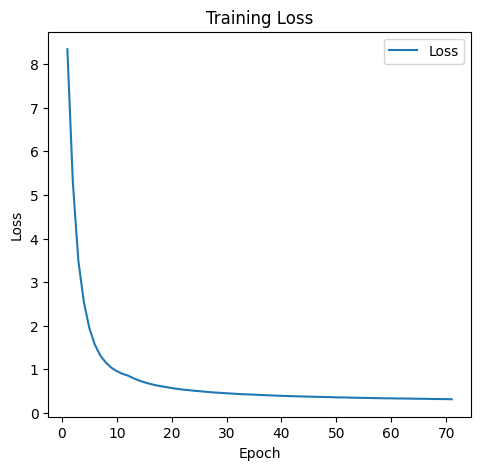

In [ ]:
# Visualization of Loss and Accuracy
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, len(loss_history) + 1), loss_history, label='Loss')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

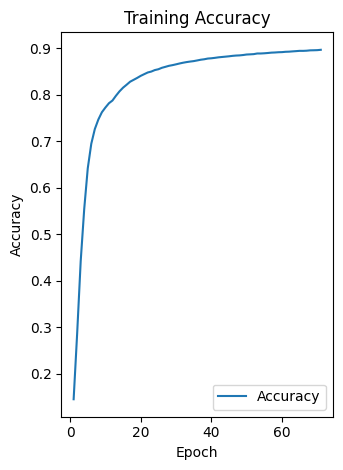

In [ ]:
# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, len(accuracy_history) + 1), accuracy_history, label='Accuracy')
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Inference

- Use the trained Transformer model to translate English sentences into French.
- Predict one word at a time, appending the predicted token to the output sequence until an `<eos>` token is generated or the maximum sequence length is reached.
- Convert the predicted token sequences back into human-readable text using the tokenizer's `sequences_to_texts` function.


In [ ]:
text = """Hello how are you doing today."""
text = "sos " + text.lower() + " eos"
inp_seq = pad_sequences(tokenizer_en.texts_to_sequences([text]), maxlen=50, padding='post')
out_seq = tf.convert_to_tensor([[tokenizer_fr.word_index["sos"]]])

enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp_seq, out_seq)
output_tokens = []

# Looping until the maximum length of the output sequence is reached or the <end> token is generated
for i in range(100):
    # Calling the Transformer model on the input and output sequences and masks
    output, attn_weights = transformer(inp=inp_seq, tar=out_seq, training=False, enc_padding_mask=enc_padding_mask, look_ahead_mask=combined_mask, dec_padding_mask=dec_padding_mask)
    # Getting the last token from the output sequence
    last_token = output[:, -1, :]

    # Getting the token with the highest probability from the last token
    predicted_token = tf.cast(tf.argmax(last_token, axis=-1), tf.int32)

    # Checking if the predicted token is the <end> token
    if predicted_token == tokenizer_fr.word_index["eos"]:
        break

    # Appending the predicted token to the output tokens list
    output_tokens.append(predicted_token[0].numpy())

    # Expand dimensions to match the shape of out_seq
    predicted_token = tf.expand_dims(predicted_token, axis=-1)

    # Concatenating the predicted token to the output sequence
    out_seq = tf.concat([out_seq, predicted_token], axis=-1)

    # Updating the mask for the output sequence
    decoder_padding_mask, look_ahead_mask = create_padding_mask(out_seq), create_look_ahead_mask(tf.shape(out_seq)[1])
    combined_mask = tf.maximum(decoder_padding_mask, look_ahead_mask)

In [ ]:
# Converting the output tokens list to a tensor
output_tokens = tf.convert_to_tensor([output_tokens])

In [ ]:
tokenizer_fr.sequences_to_texts(output_tokens.numpy())

['bonjour comment allez vous aujourd hui']

In [ ]:
tokenizer_en.sequences_to_texts(inp_seq)

['sos hello how are you doing today eos']